# 주제 : 메모리 사용량 데이터를 활용해 미래의 메모리 사용량을 예측합니다.
---

## 데이터 분석
  - 학습에 사용되는 메모리 사용량 데이터는 9월, 1 달 분량의 데이터 입니다.

  - 그 중 시간 정보 즉, **datetime** 을 사용하여 메모리 사용량, **system.memory.used.pct**를 예측합니다.

  - 또한 **cloud.instance.id**에 따라 메모리 사용량 패턴이 다르게 나타나기 때문에 *i-000001bc*라는 id를 가진 instance만 사용하고 예측함으로서 하드웨어 자원 및 시간을 절약 할 것 입니다.

## 최종 목표
  - 10월 7일까지 메모리 사용량을 예측 할 것 입니다.

  - 예측된 데이터를 기반으로 시각화 자료, 그래프를 그릴 것 입니다.

  - 실제 10월 데이터를 활용하여 예측 값 과의 차이를 **MAPE**라는 지수를 사용하여 비교 할 것 입니다.


## Step 1. 데이터셋 준비하기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

### Memory 데이터를 불러 오고 가공하는 단계입니다.

In [ ]:
memory_df = pd.read_csv("/content/drive/MyDrive/Collab/data/mem_2110/sym-metric-memory-2021-09-01.csv")
df = memory_df[['datetime','cloud.instance.id' ,'system.memory.used.pct']]
for i in range(2, 31):
    memory_df = pd.read_csv("/content/drive/MyDrive/Collab/data/mem_2110/sym-metric-memory-2021-09-"+str(i).zfill(2)+".csv")
    df = pd.concat([df, memory_df[['datetime', 'cloud.instance.id', 'system.memory.used.pct']]])
memory_df = 0

In [ ]:
df.head()

,datetime,cloud.instance.id,system.memory.used.pct
0,2021-09-01T22:16:20.000Z,i-000001bc,0.9136
1,2021-09-01T22:16:20.000Z,i-000000c7,0.6492
2,2021-09-01T22:16:20.000Z,i-00000175,0.9774
3,2021-09-01T22:16:20.000Z,i-000002ac,0.9310
4,2021-09-01T22:16:20.000Z,i-000001e8,0.2700


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df['datetime'].dt.tz_localize(None)
df.rename(columns = {'datetime' : 'ds', 'cloud.instance.id' : 'instance_id', 'system.memory.used.pct' : 'y'}, inplace = True)

In [ ]:
selected_df = df[df['instance_id'] == 'i-000001bc']
selected_df['cap'] = 1
selected_df['floor'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 검증에 사용될 10월 메모리 사용량 데이터를 불러오고 가공하는 부분 입니다.

In [ ]:
memory_true_df = pd.read_csv("/content/drive/MyDrive/Collab/data/mem_2110/sym-metric-memory-2021-10-01.csv")
df_true = memory_true_df[['datetime','cloud.instance.id' ,'system.memory.used.pct']]
for i in range(2, 8):
    memory_true_df = pd.read_csv("/content/drive/MyDrive/Collab/data/mem_2110/sym-metric-memory-2021-10-"+str(i).zfill(2)+".csv")
    df_true = pd.concat([df_true, memory_true_df[['datetime', 'cloud.instance.id', 'system.memory.used.pct']]])
memory_true_df = 0

In [ ]:
df_true['datetime'] = pd.to_datetime(df_true['datetime'])
df_true['datetime'] = df_true['datetime'].dt.tz_localize(None)
df_true.rename(columns = {'datetime' : 'ds', 'cloud.instance.id' : 'instance_id', 'system.memory.used.pct' : 'y'}, inplace = True)

In [ ]:
selected_true_df = df_true[df_true['instance_id'] == 'i-000001bc']

## Step 2. 모델 구축하기

## 휴일 정보를 추가하는 단계 입니다.

In [ ]:
nationalHolidays = pd.DataFrame({

  'holiday': 'nationalHolidays',

  'ds': pd.to_datetime(['2021-09-04','2021-09-05','2021-09-11','2021-09-12','2021-09-18','2021-09-19','2021-09-20','2021-09-21','2021-09-22','2021-09-25','2021-09-26',
                        '2021-10-01','2021-10-02','2021-10-03','2021-10-04','2021-10-09','2021-10-10','2021-10-11','2021-10-16','2021-10-17','2021-10-23','2021-10-24','2021-10-30','2021-10-31']),

})


holidays = nationalHolidays

## 실질적으로 모델을 구축하고 결과 값을 예측, 시각화 자료로 표현합니다.
저희가 사용한 모델은 ML모델로 시계열 데이터를 예측하는 Prophet입니다.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


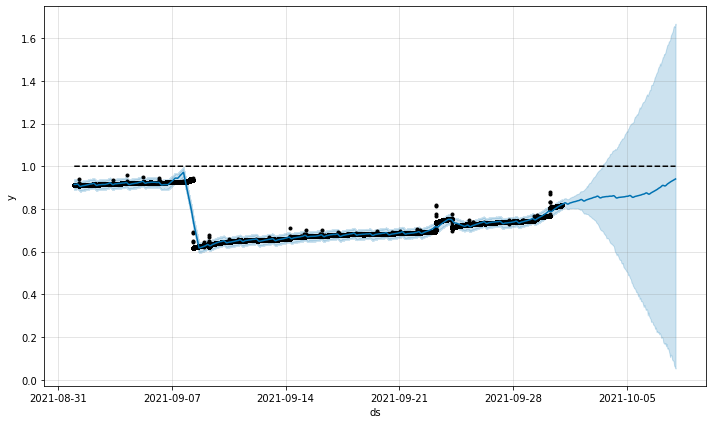

In [ ]:
from fbprophet import Prophet

m = Prophet().fit(selected_df)
future = m.make_future_dataframe(periods=168, freq='H')
future['cap'] = 1
future['floor'] = 0
fcst = m.predict(future)
fig = m.plot(fcst)

## 산출한 예측 값을 실제 값과 **MAPE**를 이용하여 비교합니다.

In [ ]:
preds = fcst[fcst['ds'] > '2021-10-01']
preds = preds[['ds', 'yhat']]
y_pred = preds['yhat']
y_pred = np.array(y_pred)

In [ ]:
y_true = selected_true_df.groupby([selected_true_df['ds'].dt.day, selected_true_df['ds'].dt.hour]).mean()['y']
y_true = np.array(y_true)

In [ ]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape

12.39555714816693

## 최종적으로 12.39555714816693 라는 MAPE값을 구하였습니다.  
이는 예측치가 실제 메모리 사용량과 약 12.396% 차이를 보인다는 의미입니다.

추가적으로 이번 모델의 성능을 높이기 위하여 총 두개의 파라미터를 실험 해 보았습니다.

**changepoint_prior_scale** 와 **holidays** 라는 파라미터 입니다.

**holidays** 를 고려한 MAPE는 12.409777919055195

**changepoint_prior_sclae** 를 변경해준 MAPE는 12.578006111575013

**양 측 모두** 를 고려한 MAPE는 12.440049921286803 

로 어떤 파라미터도 추가하지 않은 모델의 성능이 가장 뛰어나다고 판단하였습니다.